In [1]:
!pip install --user --quiet tensorflow gensim

In [2]:
! pip install --quiet kaggle
! mkdir ~/.kaggle
! echo "{\"username\":\"tupoylogin\",\"key\":\"290a55772726b66c496aa74ea7bc8a1f\"}" > ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d utkarshxy/stock-markettweets-lexicon-data 

 97% 56.0M/57.5M [00:01<00:00, 32.1MB/s]
100% 57.5M/57.5M [00:01<00:00, 36.3MB/s]


In [4]:
! mkdir train
! unzip stock-markettweets-lexicon-data.zip -d train

Archive:  stock-markettweets-lexicon-data.zip
  inflating: train/tweets_labelled_09042020_16072020.csv  
  inflating: train/tweets_remaining_09042020_16072020.csv  


In [3]:
import tensorflow as tf
import numpy as np
from gensim.models import Word2Vec

In [5]:
import gensim.downloader as api

twitter_vectors = api.load('glove-twitter-100')

[=-------------------------------------------------] 2.1% 8.1/387.1MB downloaded

KeyboardInterrupt: ignored

In [ ]:
import nltk
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
wnl = WordNetLemmatizer()

def filter_out_non_text(text: str) -> str:
  filtered_text = repr(text.encode('utf-8'))[2:-1]
  filtered_text = filtered_text.replace('\\n',' ')
  filtered_text = re.sub(r"won\'t", "will not", filtered_text)
  filtered_text = re.sub(r"can\'t", "can not", filtered_text)
  filtered_text = re.sub(r"n\'t", " not", filtered_text)
  filtered_text = re.sub(r"\'re", " are", filtered_text)
  filtered_text = re.sub(r"(he|He)\'s", "he is", filtered_text)
  filtered_text = re.sub(r"(she|She)\'s", "she is", filtered_text)
  filtered_text = re.sub(r"(it|It)\'s", "it is", filtered_text)
  filtered_text = re.sub(r"\'d", " would", filtered_text)
  filtered_text = re.sub(r"\'ll", " will", filtered_text)
  filtered_text = re.sub(r"\'t", " not", filtered_text)
  filtered_text = re.sub(r"[#@]", "", filtered_text)
  filtered_text = re.sub(r"(\'ve|has)", " have", filtered_text)
  filtered_text = re.sub(r"\'m", " am", filtered_text)
  filtered_text = re.sub(r"\\x[a-f0-9]*", "", filtered_text)
  filtered_text = filtered_text.split(' ')
  filtered_text = ' '.join([
      wnl.lemmatize(word.lower()) for word in filtered_text if word.isalpha() and word.lower() not in stopwords.words('english')
      ])
  return filtered_text

In [ ]:
import pandas as pd

text = pd.read_csv('train/tweets_labelled_09042020_16072020.csv', sep=';')

In [ ]:
filtered_text = text['text'].map(filter_out_non_text)

In [ ]:
text.head(10)

,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive
3,760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive
5,27027,2020-04-12 21:52:56+00:00,RT @QuantTrend: Reduce your portfolio RISK! GO...,positive
6,472959,2020-06-09 05:23:06+00:00,$863.69 Million in Sales Expected for Spirit A...,positive
7,392845,2020-06-02 01:12:29+00:00,RT @ArjunKharpal: #Apple has cut the prices of...,negative
8,313771,2020-05-07 04:58:41+00:00,RT @SMA_alpha: The #CDC U.S. New Case data has...,negative
9,267894,2020-05-04 15:16:29+00:00,Where to Look for Dependable Dividends\nRead M...,neutral


In [ ]:
filtered_list = list(map(lambda sentence: sentence.split(' '), filtered_text.values.tolist()))

In [ ]:
model_w2v = Word2Vec(filtered_list, size = 100, window = 10, workers = 4, iter=50, negative=5, min_count=3)

In [ ]:
model_w2v.wv.most_similar('apple', topn=15)

[('macbook', 0.803277313709259),
 ('iphone', 0.7935967445373535),
 ('maker', 0.7507783770561218),
 ('store', 0.7463147640228271),
 ('ordered', 0.733364462852478),
 ('bookstore', 0.706890881061554),
 ('expand', 0.7002881169319153),
 ('episode', 0.6992686986923218),
 ('reportedly', 0.6909438371658325),
 ('goo', 0.6878138780593872),
 ('pc', 0.6746941208839417),
 ('possibly', 0.6729687452316284),
 ('facebook', 0.6685755252838135),
 ('music', 0.6606248617172241),
 ('microsoft', 0.6487978100776672)]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(filtered_text)
vectorizer.get_feature_names_out().shape

(8562,)

In [ ]:
def get_relevant_terms(sentence, threshold):
  relevant_pairs = np.argwhere(X[sentence]>threshold)
  relevant_items = relevant_pairs[:,1].flatten()
  return  ' '.join(Y[relevant_items])
  #list(filter(lambda score: score>threshold, X[sentence].toarray()[sentence]))

In [ ]:
get_relevant_terms(0, 0.1 )

'crash enter learn market monarch token video watch win yo'

In [ ]:
texts = []
for i in range(len(text)):
  texts.append(get_relevant_terms(i, 0.2)) 

print(texts[:10])

['crash enter learn monarch token video watch win yo', 'amaraweera diesel fuel fuelprices imposed lka midnight minister petrol revoked srilanka surcharge transport', 'correct emfx fiscal fund increase issuance net program spike unemployment ycc yield', 'find help ip much running served tool traffic', 'amd cnbc cpu desktop great launch looking madtweets ryzen track', 'balance bank central deficit expansion fiscal gold large perfect portfolio reduce sheet tail', 'aerosystems expected million quarter sale spirit', 'apple cut discount iphone price range uncommon', 'case cdc data decline encouraging flat global new saw', 'business dependable dividend etf investing look news read']


In [ ]:
dataset = text[['sentiment']]
dataset['texts'] = filtered_text

dataset.head()

<ipython-input-15-9e02c38433dd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['texts'] = filtered_text


,sentiment,texts
0,positive,rt yo enter win monarch token u stock market c...
1,negative,srilanka surcharge fuel surcharge imposed dies...
2,positive,net issuance increase fund fiscal program yiel...
3,positive,rt much traffic served help u find running too...
4,positive,ryzen desktop cpu looking great track launch m...


In [ ]:
all_vocab = twitter_vectors.wv.index2word[:]
#all_vocab.extend(model_w2v.wv.index2word)
#all_vocab = list(set(all_vocab))

<ipython-input-66-f36f6ee07104>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  all_vocab = twitter_vectors.wv.index2word[:]


In [ ]:
def construct_vocabulary():
  res = []
  for word in all_vocab:
    if word != '':
        res.append(twitter_vectors.wv[word])
  return np.vstack(res)

In [ ]:
vocabulary = construct_vocabulary(model_w2v)

<ipython-input-67-d95954151213>:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  res.append(twitter_vectors.wv[word])


In [ ]:
all_vocab = [x for x in all_vocab if x!='']

In [ ]:
class SentimentModel(tf.keras.Model):
  def __init__(self, 
               max_token: int,
               kernel_size: int,
               filters: int):
    super().__init__(self)
    self.vectorizer=tf.keras.layers.TextVectorization(output_sequence_length=max_token, vocabulary=all_vocab)
    self.embeddings=tf.keras.layers.Embedding(len(all_vocab), 100, weights=tf.constant([vocabulary]))
    self.embeddings.trainable=False
    self.conv_1=tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')
    self.conv_2=tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')
    self.conv_3=tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')
    self.average = tf.keras.layers.AveragePooling1D(2)
    self.flatten = tf.keras.layers.Flatten()
    self.dense = tf.keras.layers.Dense(64, activation='relu')
    self.output_layer = tf.keras.layers.Dense(3)
    
  def call(self, input_):
    o=self.vectorizer(input_)
    o=self.embeddings(o)
    o=self.conv_1(o)
    o=self.conv_2(o)
    o=self.conv_3(o)
    o=self.average(o) 
    o=self.flatten(o)
    o=self.dense(o) 
    o=self.output_layer(o) 
    return o

In [ ]:
semantic_model = SentimentModel(max_token=50, kernel_size=2, filters=64)

In [ ]:
semantic_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
dataset = dataset[~dataset.sentiment.isna()]

In [ ]:
y = pd.get_dummies(dataset['sentiment'])

In [ ]:
semantic_model.fit(x=dataset[['texts']].values, y=y.values, epochs=15, batch_size=64)

Epoch 1/15
21/21 [==============================] - 56s 2s/step - loss: 1.0902 - precision_6: 0.6364 - recall_6: 0.0054
Epoch 2/15
21/21 [==============================] - 36s 2s/step - loss: 1.0443 - precision_6: 0.6271 - recall_6: 0.0854
Epoch 3/15
21/21 [==============================] - 37s 2s/step - loss: 1.0076 - precision_6: 0.6162 - recall_6: 0.1815
Epoch 4/15
21/21 [==============================] - 33s 2s/step - loss: 0.9317 - precision_6: 0.7091 - recall_6: 0.2831
Epoch 5/15
21/21 [==============================] - 34s 2s/step - loss: 0.8186 - precision_6: 0.7098 - recall_6: 0.4892
Epoch 6/15
21/21 [==============================] - 34s 2s/step - loss: 0.6893 - precision_6: 0.7700 - recall_6: 0.6154
Epoch 7/15
21/21 [==============================] - 34s 2s/step - loss: 0.6181 - precision_6: 0.7450 - recall_6: 0.7100
Epoch 8/15
21/21 [==============================] - 34s 2s/step - loss: 0.4909 - precision_6: 0.7956 - recall_6: 0.8054
Epoch 9/15
21/21 [======================

In [ ]:
y.columns[np.argmax(semantic_model.predict([['apple price crashes rapidly']]))]

1/1 [==============================] - 4s 4s/step


'negative'

In [ ]:
semantic_model.save("sentiment_analysis_model")

In [ ]:
!pip install yfinance

In [6]:
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

Selecting previously unselected package libta-lib0.
(Reading database ... 128276 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.0/272.0 KB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ta-lib: filename=TA_Lib-0.4.25-cp39-cp39-linux_x86_64.whl size=2261292 sha256=28319f1be8278da9045649d9a9a93

In [ ]:
! wget https://algoseek-public.s3.amazonaws.com/nasdaq100-1min.zip &&  unzip nasdaq100-1min.zip -d train

In [8]:
! zip -r sentiment_analysis_model.zip /content/sentiment_analysis_model

	zip warning: name not matched: /content/sentiment_analysis_model

zip error: Nothing to do! (try: zip -r sentiment_analysis_model.zip . -i /content/sentiment_analysis_model)


In [9]:
columns = ['FirstTradePrice', 'FirstTradeSize', 'LastTradePrice', 'LastTradeSize', 'VolumeWeightPrice', 'LowTradePrice', 'LowTradeSize', 'HighTradePrice', 'HighTradeSize', 'Volume']

In [10]:
import talib
import gzip
import typing as tp
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict
import os
tickers = ['AAPL', 'TSLA', 'MSFT']

def read_tickers(tickers: tp.List[str]) -> pd.DataFrame:
  """
  Read tickers
  """
  tickers_dict = defaultdict(list)
  files_to_parse = [f"{ticker}.csv.gz" for ticker in tickers]
  for folder, _, __ in tqdm(os.walk('train/nasdaq100/'), desc='Reading stocks'):
    for ticker, filename in zip(tickers, files_to_parse):
      if os.path.isfile(os.path.join(folder, filename)):
        with gzip.open(os.path.join(folder, filename)) as f:
          ticker_df = pd.read_csv(f)
          tickers_dict[ticker].append(ticker_df)
  for ticker in tickers:
    tickers_dict[ticker] = pd.concat(tickers_dict[ticker])
    df = tickers_dict[ticker].copy()
    df['Date'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['TimeBarStart'], format='%Y%m%d %H:%M:%S')
    tickers_dict[ticker] = df.sort_values(by='Date').set_index('Date')[columns]
  return tickers_dict

def plot_tickers(tickers_dataset: pd.DataFrame, name: str = 'Stock Prices'):
  """
  Plot tickers from tickers dataset
  """
  number_of_plots = len(tickers_dataset.columns)
  fig, ax = plt.subplots(number_of_plots, figsize=(15, 10))
  fig.suptitle(name)
  for idx, ticker in enumerate(tickers_dataset.columns):
    if number_of_plots > 1:
      axis = ax[idx]
    else:
      axis = ax
    axis.plot(tickers_dataset.index.values.ravel(), tickers_dataset[ticker].values.ravel())
    axis.set(ylabel=ticker)
  plt.show()

def shift_data(tickers_dataset, y_col, days_shift):
  """
  Add to data some lags for given column
  """
  new_dataset = tickers_dataset.copy()
  for lag in range(1, days_shift + 1):
    new_dataset[f'{y_col}_-{lag}'] = new_dataset[y_col].shift(lag)

  return new_dataset

In [56]:
dict_nasdaq = read_tickers(tickers)

Reading stocks: 0it [00:00, ?it/s]

In [12]:
import matplotlib.pyplot as plt

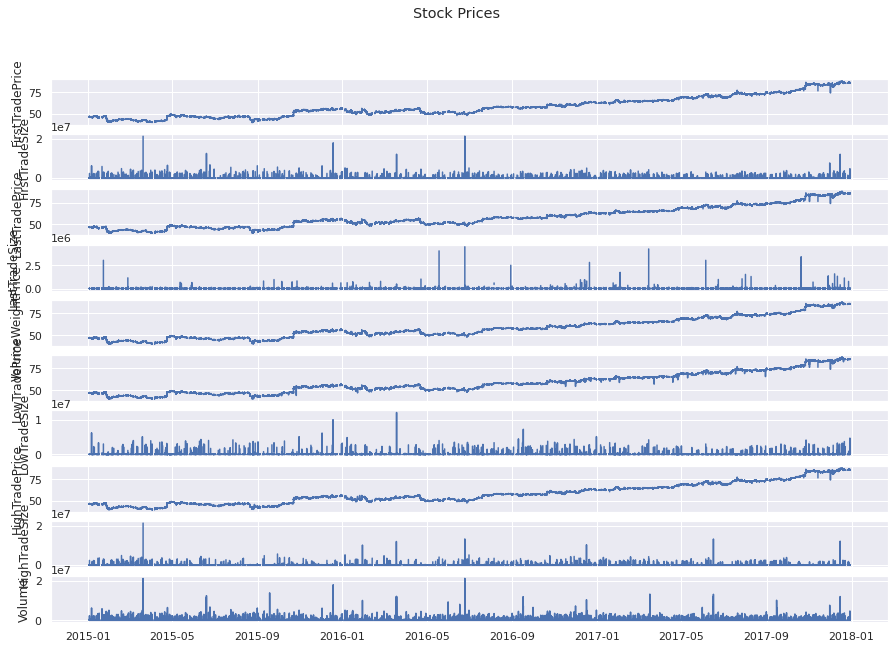

In [57]:
plot_tickers(dict_nasdaq['MSFT'])

In [58]:
def compute_return_for_k_hours(df: pd.DataFrame, k: int = 0):
  column_name = 'Return' + (f'{k}_hours' if k else '')
  df[column_name] = df['LastTradePrice'].div(df['FirstTradePrice'].shift(k*60)).sub(1)

In [59]:
compute_return_for_k_hours(dict_nasdaq['MSFT'], 2)

In [60]:
for t in tickers:
  for k in range(0,24,4):
    compute_return_for_k_hours(dict_nasdaq[t], k)

1. Balance of Power:  
$ BOP = \frac{Close_{i} - Open_{i}}{High_{i} - Low{i}} $
2. Commodity Channel Index:  
$ CCI = \frac{TypicalPrice-MA}{0.15 \times MeanDeviation}$
3. Money Flow Index:  
$ MFI = 100 - \frac{100}{ 1 + MoneyFlowRatio}$
4. Stochastic RSI:  
$ StochRSI = \frac{RSI_{i} - MIN[RSI]_{i}}{MAX[RSI]_{i} - MIN[RSI]_{i}}$  ,  
$RSI$ - [Relative Strength index](https://en.wikipedia.org/wiki/Relative_strength_index)


In [72]:
def compute_stoch(x: pd.DataFrame, 
                  fastk_period: int = 14, 
                  slowk_period: int = 3, 
                  slowk_matype: int = 0, 
                  slowd_period: int = 3, 
                  slowd_matype: int = 0):
  slowk, slowd = talib.STOCH(x.HighTradePrice.ffill(), x.LowTradePrice.ffill(), x['LastTradePrice'].ffill(), 
                               fastk_period=fastk_period,
                               slowk_period=slowk_period,
                               slowk_matype=slowk_matype,
                               slowd_period=slowd_period,
                               slowd_matype=slowd_matype)
  x['slowd'] = slowd
  x['slowk'] = slowk

def compute_bop(x: pd.DataFrame):
  x['BOP'] = talib.BOP(x['FirstTradePrice'],
                       x['HighTradePrice'],
                       x['LowTradePrice'],
                       x['LastTradePrice'])

def compute_cci(x: pd.DataFrame):
  x['CCI'] = talib.CCI(x['HighTradePrice'],
                       x['LowTradePrice'],
                       x['LastTradePrice'])
  
def compute_mfi(x: pd.DataFrame, timeperiod: int = 14):
  x['MFI'] = talib.MFI(x['HighTradePrice'],
                       x['LowTradePrice'],
                       x['LastTradePrice'],
                       x['Volume'],
                       timeperiod=timeperiod)

def compute_wma(x: pd.DataFrame, column: str):
  x['WMA_'+column] = talib.WMA(x[column].fillna(method='pad'))

In [73]:
for t in tickers:
  compute_stoch(dict_nasdaq[t])
  compute_bop(dict_nasdaq[t])
  compute_cci(dict_nasdaq[t])
  compute_mfi(dict_nasdaq[t])
  compute_wma(dict_nasdaq[t], ('FirstTradePrice'))
  compute_wma(dict_nasdaq[t], ('LastTradePrice'))
  compute_wma(dict_nasdaq[t], ('VolumeWeightPrice'))
  compute_wma(dict_nasdaq[t], ('LowTradePrice'))
  compute_wma(dict_nasdaq[t], ('HighTradePrice'))


In [74]:
dict_nasdaq['AAPL'].dropna()

,FirstTradePrice,FirstTradeSize,LastTradePrice,LastTradeSize,VolumeWeightPrice,LowTradePrice,LowTradeSize,HighTradePrice,HighTradeSize,Volume,...,slowk,BOP,CCI,MFI,WMA,WMA_FirstTradePrice,WMA_LastTradePrice,WMA_VolumeWeightPrice,WMA_LowTradePrice,WMA_HighTradePrice
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05 09:04:00,108.6500,100.0,108.6500,200.0,108.63292,108.610,190.0,108.650,100.0,1711,...,55.555556,0.000000,57.320099,20.790572,108.662946,108.650925,108.647075,108.647806,108.632000,108.662946
2015-01-05 10:05:00,107.8801,50.0,107.8365,231.0,107.84527,107.770,96.0,107.885,1.0,128971,...,81.361717,-0.379130,97.490934,52.434630,107.898848,107.817223,107.812958,107.794888,107.696383,107.898848
2015-01-05 10:12:00,107.9799,3.0,107.9000,1100.0,107.92708,107.820,46.0,108.000,50.0,120851,...,84.229730,-0.443889,53.184533,49.882232,107.898449,107.829358,107.833016,107.820505,107.737851,107.898449
2015-01-05 10:32:00,107.9000,88.0,107.7500,100.0,107.82792,107.731,100.0,107.910,200.0,56523,...,25.000000,-0.837989,-111.938939,51.392737,108.011744,107.957118,107.943632,107.957963,107.889439,108.011744
2015-01-05 10:55:00,107.7301,8.0,107.7000,10.0,107.69065,107.620,100.0,107.770,15.0,47688,...,68.279727,-0.200667,81.377459,60.390182,107.729235,107.641987,107.642154,107.646957,107.585221,107.729235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-29 17:06:00,169.1500,25.0,169.1500,1.0,169.15000,169.150,25.0,169.150,25.0,26,...,33.333333,0.000000,28.482003,41.418974,169.170409,169.160710,169.154280,169.153607,169.146817,169.170409
2017-12-29 17:09:00,169.1500,100.0,169.1500,100.0,169.15000,169.150,100.0,169.150,100.0,200,...,88.888889,0.000000,133.333333,58.899226,169.163032,169.154538,169.150882,169.151306,169.144581,169.163032
2017-12-29 17:11:00,169.1500,1.0,169.1500,1.0,169.15000,169.150,1.0,169.150,1.0,1,...,100.000000,0.000000,110.975610,39.622095,169.159140,169.150860,169.149505,169.149978,169.143290,169.159140


In [62]:
sample = dict_nasdaq['AAPL'].sample(n=30_000)

<ipython-input-66-207d8ed0a2ce>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample[feature], ax=axes[i])
<ipython-input-66-207d8ed0a2ce>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample[feature], ax=axes[i])
<ipython-input-66-207d8ed0a2ce>:5: UserWarning: 

`distplot` is a deprecated

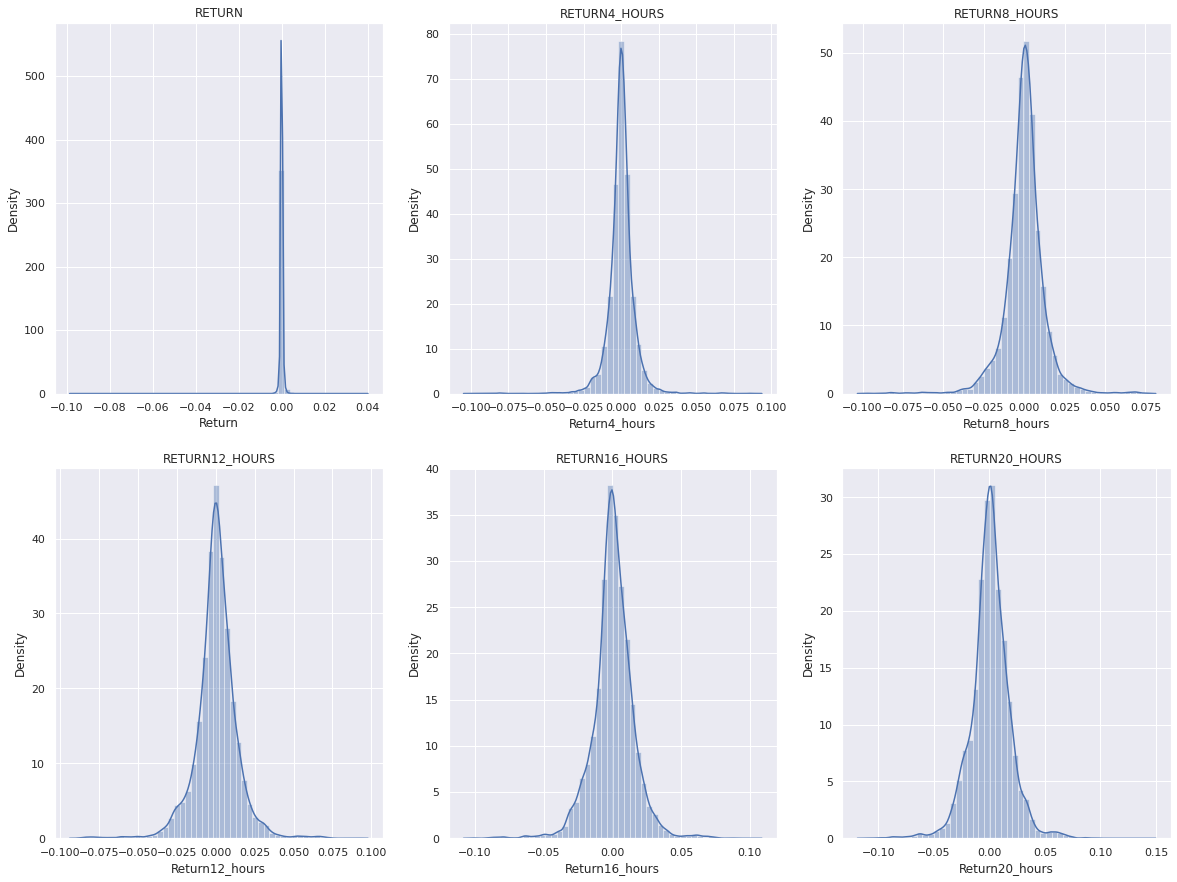

In [66]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))
axes = axes.flatten()
returns = ['Return' + (f'{k}_hours' if k else '') for k in range(0,24,4)]
for i, feature in enumerate(returns):
    sns.distplot(sample[feature], ax=axes[i])
    axes[i].set_title(feature.upper())

In [54]:
import gc
del  dict_nasdaq
gc.collect()

33494

In [ ]:
! kaggle datasets download -d omermetinn/tweets-about-the-top-companies-from-2015-to-2020

 95% 265M/278M [00:05<00:00, 32.0MB/s]
100% 278M/278M [00:05<00:00, 50.2MB/s]
